# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a same floor plan (input layer -> one or more hidden layers -> output layer).

Before writing code, this is the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass Classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g., 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10–512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g., 3 for food, person, or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit), but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)) | [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (Stochastic Gradient Descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) — see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options | Same as binary classification |

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Create 1000 samples
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples,
                    noise=0.03,        # noise to the dots
                    random_state=42)   # reproducibility

In [2]:
print(f"First 5 values of feature X:\n{X[:5]}")
print(f"\nFirst 5 values of label y:\n{y[:5]}")

First 5 values of feature X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 values of label y:
[1 1 1 1 0]


In [3]:
# There are 2 Xs for 1 y
# Create a dataframe using X and y (X[:0] for X1, X[:1] for X2, label for y)
# visualize, visualize, visualize
import pandas as pd

circles = pd.DataFrame({
    'X1': X[:,0],
    'X2': X[:,1],
    'label': y,
})

circles.head(10)

X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0

In [4]:
# label are 0 and 1, this tells us that our case i binary classification (two options)
# Check label 
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

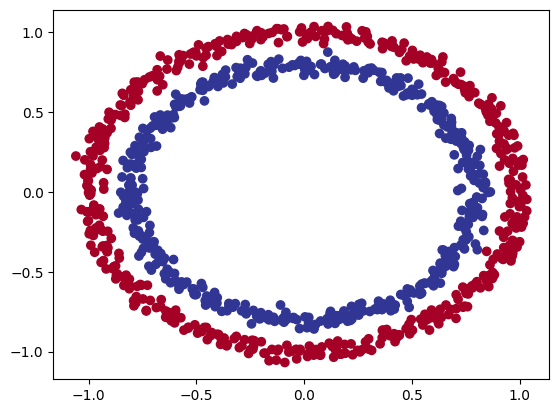

In [5]:
# balance like cash flow haha, 
# it is time to plot the data!
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Input and Output shapes

In [6]:
# Always ask yourself "What shapes are my inputs and what shapes are my outputs?"
# And don't forget to check it 
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


- X_sample is a vector with 2 features 
- y_sample is scalar because it only has 1 feature
- model will receive 2 input features dan generate 1 label
- ``` Input (X): [feature_1, feature_2]  -->  Output (y): label ```
- ``` Input layer: 2 neuron  →  Output layer: 1 neuron ```

### 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data indo tensors
# Otherwise this causes issues with computations later on 
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Display first 5 values of tensor X and y
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 200, 800, 200)

## Building a model

In [10]:
# Standard PyTorch imports 
from torch import nn 

# Make device agnostic code
# So our model can run on CPU and GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features (5 hidden units/neurons)
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation 
    def forward(self, x):
        # Return the output of layer_2, a scalar, same shape as y
        return self.layer_2(self.layer_1(x)) # Computation goes through layer_1 first, then the output of layer_1 goes to layer_2

# 4. Create an instance of the model and send it to target device 
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

- 5 features produced from layer_1 potentially leading to a better outputs rather than just 2 numbers
- potentially because sometimes it doesn't work hahaha
- The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

# Getting Binary Classification Data Ready
For starter purpose, we will create a simple binary classification dataset. But remember, for deep learning, input can be almost anything.

In [ ]:
//

# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a sam floor plan (input layer -> one or more hidden layers -> output layer).

# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a sam floor plan (input layer -> one or more hidden layers -> output layer).

# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a sam floor plan (input layer -> one or more hidden layers -> output layer).

# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a sam floor plan (input layer -> one or more hidden layers -> output layer).

# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a sam floor plan (input layer -> one or more hidden layers -> output layer).

# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a sam floor plan (input layer -> one or more hidden layers -> output layer).

# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a sam floor plan (input layer -> one or more hidden layers -> output layer).